In [1]:
from __future__ import (absolute_import, division, print_function)
from six.moves import (filter, input, map, range, zip)  # noqa
import matplotlib.pyplot as plt
#import iris
#import iris.analysis
#import iris.analysis.cartography
import numpy as np

from sklearn.linear_model import LinearRegression
import warnings

#outputs 50x30 matrix of 1's and 0's where 1's correspond to warm event

import copy
import numpy as np



'''
n=0 : 1902-1932
n=1 : 1912-1942
n=2 : 1922-1952
n=3 : 1932-1962
n=4 : 1942-1972
n=5 : 1952-1982
n=6 : 1962-1992
n=7 : 1972-2002
'''
n=0
a=n*10
#a=79

total=31*40
time=31
b=a+31
"""
b=109
time=109
total=109*51
"""

'\nb=109\ntime=109\ntotal=109*51\n'

In [2]:
s=str()

s='1980-2010'
'''
s='1902-2010'


if n==0 : 
    s= '1902-1932'
elif n==1 : s='1912-1942'
elif n==2 : s='1922-1952'
elif n==3 : s='1932-1962'
elif n==4 : s='1942-1972'
elif n==5 : s='1952-1982'
elif n==6 : s='1962-1992'
elif n==7 : s='1972-2002'
'''
print(s)

1980-2010


In [5]:
def lower_tercile_dp3(a,b,time,total,data,data_obs,label):

    PCs_data_full = data
    PCs_full=PCs_data_full.reshape(40, 40)
    PCs=PCs_full[:,a:b]
    PCs_data = PCs.reshape(40*time)
    PCs_data_copy = copy.copy(PCs_data)
    val= np.percentile(PCs_data, 33, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    for m in range(total):
        if PCs_data[m] < val :
            PCs_data_copy[m]=1
        else :
            PCs_data_copy[m]=0

        #print(ens_1o)

    PCs_binary=PCs_data_copy.reshape(40, time)

    #probabilities of warm winter for each year
    binary_matrix=PCs_binary
    #sum columns to give number of ensembles that say warm event for that year
    column_sums = binary_matrix.sum(axis=0)

    probabilities= column_sums/40

    prob= np.zeros(time*3).reshape((time,3))
    prob[:,1]= probabilities
    prob[:,0]=np.arange(time)
    prob_copy = copy.copy(prob[:])

    bins=np.arange(0,1.1,0.1)
    #to catagorize probabilities into correct bins
    for n in range(1,11):
        for p in range(time):
            if bins[n-1]<=prob[p,1]< bins[n] :
                prob_copy[p,2]=n
    
    #observed data:
    #sort observed data and set lower tercile(warm events) to 1
    obsv= np.zeros(time*3).reshape((time,3))
    obsv[:,1]= data_obs
    obsv[:,0]=np.arange(time)

    val_o= np.percentile(data_obs, 33 , axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    for n in range(1,time+1):
            if obsv[n-1,1] < val_o :
                obsv[n-1,1]=1
            else :      obsv[n-1,1]=0

    #obsv_re_sort is an array of years and corresponding 1's and 0's for cold winters over UK
    obsv_bins= np.zeros(time*4).reshape((time,4))

    obsv_bins[:,0]=obsv[:,0]
    obsv_bins[:,1]=obsv[:,1]
    obsv_bins[:,2]=prob_copy[:,2]
    obsv_bins[:,3]=prob_copy[:,1]
    obsv_bins_sort= obsv_bins[obsv_bins[:, 2].argsort()]
    #obsv_bins_sort is array with corresponding bin of year from forecast data

    y_co=np.zeros(10)
    x_co=np.zeros(10)
    C=np.zeros(40).reshape((10,4))

    for n in range(1,11):
        A=np.zeros(time*4).reshape((time,4))
        for p in range(1,time+1):
            if n == obsv_bins_sort[p-1,2]:
                A[p-1,:]=obsv_bins_sort[p-1,:]
        B=A.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin
        D=B[2]/n #no. of years in bin
        F=B[3] # to avg x coord
        E=[n,B[1],D,0]
        C[n-1,:]=E
        y_co[n-1]= E[1]/E[2]
        x_co[n-1]=F/D

    coords=np.zeros(40).reshape((10,4))
    coords[:,0]=x_co
    coords[:,1]=y_co
    coords[:,2]=C[:,2]
    #print(coords)
    coords_new=coords[~np.isnan(coords).any(axis=1)]

    size=coords_new[:,2]
    sh=coords_new[:,0].size
    coords_new[:,3]=sh

    a_file = open("NAO_"+s+label+"_coords_lower_tercile.txt", "w")
    for row in coords_new:
        np.savetxt(a_file, row)
    a_file.close()
    
    rego= np.zeros(1000)

    for i in range(1000):
        
        random_indices = np.random.choice(time, size=time, replace=True)
        rand_sample = obsv_bins_sort[random_indices,:]
        #sum columns to give number of ensembles that say warm event for that year
        y_co_unc=np.zeros(10)
        x_co_unc=np.zeros(10)
        C_unc=np.zeros(40).reshape((10,4))

        for n in range(1,11):
            A_unc=np.zeros(4*time).reshape((time,4))
            for p in range(1,time+1):
                if n == rand_sample[p-1,2]:
                    A_unc[p-1,:]=rand_sample[p-1,:]

            B_unc=A_unc.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin
            D_unc=B_unc[2]/n #no. of years in bin
            F_unc=B_unc[3] #avg x coord
            E_unc=[n,B_unc[1],D_unc,0]
            C_unc[n-1,:]=E_unc
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', RuntimeWarning)
                y_co_unc[n-1]= E_unc[1]/E_unc[2]
                x_co_unc[n-1]=F_unc/D_unc

        coords_unc=np.zeros(30).reshape((10,3))
        coords_unc[:,0]=x_co_unc
        coords_unc[:,1]=y_co_unc
        coords_unc[:,2]=C_unc[:,2]
        coords_new_unc=coords_unc[~np.isnan(coords_unc).any(axis=1)]

        size_unc=coords_new_unc[:,2]
        sh_unc=coords_new_unc[:,0].size

        p_unc=coords_new_unc[:,0].reshape(-1,1)
        q_unc=coords_new_unc[:,1]
        model_unc= LinearRegression()
        model_unc.fit(p_unc,q_unc,size_unc[0:sh_unc])
        p_new_unc = coords_new_unc[:,0]
        q_new_unc = model_unc.predict(p_new_unc[:, np.newaxis])
        rego[i]=model_unc.coef_

    unc_reg_l= np.zeros(2)
    unc_reg_l[0]= np.percentile(rego, 12, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    unc_reg_l[1]= np.percentile(rego, 87, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    a_file = open("uncert_reg_l"+s+label+".txt", "w")
    np.savetxt(a_file, unc_reg_l)
    a_file.close()


data=np.loadtxt("dp3_data.txt")
#data_mag=abs(data_mag)
obs_dataun=np.loadtxt("NAO_EOF_ERA20C_1901-2010.txt")
data_obsmag=obs_dataun[78:110]
data_obs=data_obsmag
label='dp3'
lower_tercile_dp3(a,b,time,total,data,data_obs, label)





/tmp/user/22734/ipykernel_2426564/2311346129.py:76: RuntimeWarning: invalid value encountered in double_scalars
  y_co[n-1]= E[1]/E[2]
/tmp/user/22734/ipykernel_2426564/2311346129.py:77: RuntimeWarning: invalid value encountered in double_scalars
  x_co[n-1]=F/D


In [6]:
def upper_tercile_dp3(a,b,time,total,data,data_obs,label):

    PCs_data_full = data
    PCs_full=PCs_data_full.reshape(40, 40)
    PCs=PCs_full[:,a:b]
    PCs_data = PCs.reshape(40*time)
    PCs_data_copy = copy.copy(PCs_data)
    val= np.percentile(PCs_data, 67, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    for m in range(total):
        if PCs_data[m] > val :
            PCs_data_copy[m]=1
        else :
            PCs_data_copy[m]=0

        #print(ens_1o)

    PCs_binary=PCs_data_copy.reshape(40, time)

    #probabilities of warm winter for each year
    binary_matrix=PCs_binary
    #sum columns to give number of ensembles that say warm event for that year
    column_sums = binary_matrix.sum(axis=0)

    probabilities= column_sums/40

    prob= np.zeros(time*3).reshape((time,3))
    prob[:,1]= probabilities
    prob[:,0]=np.arange(time)
    prob_copy = copy.copy(prob[:])

    bins=np.arange(0,1.1,0.1)
    #to catagorize probabilities into correct bins
    for n in range(1,11):
        for p in range(time):
            if bins[n-1]<=prob[p,1]< bins[n] :
                prob_copy[p,2]=n
    
    #observed data:
    #sort observed data and set lower tercile(warm events) to 1
    obsv= np.zeros(time*3).reshape((time,3))
    obsv[:,1]= data_obs
    obsv[:,0]=np.arange(time)

    val_o= np.percentile(data_obs, 67 , axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    for n in range(1,time+1):
            if obsv[n-1,1] > val_o :
                obsv[n-1,1]=1
            else :      obsv[n-1,1]=0
    #obsv_re_sort is an array of years and corresponding 1's and 0's for cold winters over UK
    obsv_bins= np.zeros(time*4).reshape((time,4))

    obsv_bins[:,0]=obsv[:,0]
    obsv_bins[:,1]=obsv[:,1]
    obsv_bins[:,2]=prob_copy[:,2]
    obsv_bins[:,3]=prob_copy[:,1]
    obsv_bins_sort= obsv_bins[obsv_bins[:, 2].argsort()]
    #obsv_bins_sort is array with corresponding bin of year from forecast data

    y_co=np.zeros(10)
    x_co=np.zeros(10)
    C=np.zeros(40).reshape((10,4))

    for n in range(1,11):
        A=np.zeros(time*4).reshape((time,4))
        for p in range(1,time+1):
            if n == obsv_bins_sort[p-1,2]:
                A[p-1,:]=obsv_bins_sort[p-1,:]
        B=A.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin
        D=B[2]/n #no. of years in bin
        F=B[3] # to avg x coord
        E=[n,B[1],D,0]
        C[n-1,:]=E
        y_co[n-1]= E[1]/E[2]
        x_co[n-1]=F/D

    coords=np.zeros(40).reshape((10,4))
    coords[:,0]=x_co
    coords[:,1]=y_co
    coords[:,2]=C[:,2]
    coords_new=coords[~np.isnan(coords).any(axis=1)]
    print(coords_new)
    size=coords_new[:,2]
    sh=coords_new[:,0].size
    coords_new[:,3]=sh

    a_file = open("NAO_"+s+label+"_coords_upper_tercile.txt", "w")
    for row in coords_new:
        np.savetxt(a_file, row)
    a_file.close()
    
    rego= np.zeros(1000)

    for i in range(1000):
        
        random_indices = np.random.choice(time, size=time, replace=True)
        rand_sample = obsv_bins_sort[random_indices,:]
        #sum columns to give number of ensembles that say warm event for that year
        y_co_unc=np.zeros(10)
        x_co_unc=np.zeros(10)
        C_unc=np.zeros(40).reshape((10,4))

        for n in range(1,11):
            A_unc=np.zeros(4*time).reshape((time,4))
            for p in range(1,time+1):
                if n == rand_sample[p-1,2]:
                    A_unc[p-1,:]=rand_sample[p-1,:]

            B_unc=A_unc.sum(axis=0)#so B[1] is number of observed occurances (1's) in bin
            D_unc=B_unc[2]/n #no. of years in bin
            F_unc=B_unc[3] #avg x coord
            E_unc=[n,B_unc[1],D_unc,0]
            C_unc[n-1,:]=E_unc
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', RuntimeWarning)
                y_co_unc[n-1]= E_unc[1]/E_unc[2]
                x_co_unc[n-1]=F_unc/D_unc

        coords_unc=np.zeros(30).reshape((10,3))
        coords_unc[:,0]=x_co_unc
        coords_unc[:,1]=y_co_unc
        coords_unc[:,2]=C_unc[:,2]
        coords_new_unc=coords_unc[~np.isnan(coords_unc).any(axis=1)]

        size_unc=coords_new_unc[:,2]
        sh_unc=coords_new_unc[:,0].size

        p_unc=coords_new_unc[:,0].reshape(-1,1)
        q_unc=coords_new_unc[:,1]
        model_unc= LinearRegression()
        model_unc.fit(p_unc,q_unc,size_unc[0:sh_unc])
        p_new_unc = coords_new_unc[:,0]
        q_new_unc = model_unc.predict(p_new_unc[:, np.newaxis])
        rego[i]=model_unc.coef_

    unc_reg_l= np.zeros(2)
    unc_reg_l[0]= np.percentile(rego, 12, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    
    unc_reg_l[1]= np.percentile(rego, 87, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)    

    a_file = open("uncert_reg_u"+s+label+".txt", "w")
    np.savetxt(a_file, unc_reg_l)
    a_file.close()


data=np.loadtxt("dp3_data.txt")
#data_mag=abs(data_mag)
obs_dataun=np.loadtxt("NAO_EOF_ERA20C_1901-2010.txt")
data_obsmag=obs_dataun[78:110]
data_obs=data_obsmag
label='dp3'
upper_tercile_dp3(a,b,time,total,data,data_obs, label)





/tmp/user/22734/ipykernel_2426564/1342864647.py:75: RuntimeWarning: invalid value encountered in double_scalars
  y_co[n-1]= E[1]/E[2]
/tmp/user/22734/ipykernel_2426564/1342864647.py:76: RuntimeWarning: invalid value encountered in double_scalars
  x_co[n-1]=F/D


[[ 0.1375      0.          2.          0.        ]
 [ 0.26153846  0.15384615 13.          0.        ]
 [ 0.35714286  0.28571429  7.          0.        ]
 [ 0.42857143  0.57142857  7.          0.        ]
 [ 0.525       1.          2.          0.        ]]


[2.47397322]
[1.6591642]


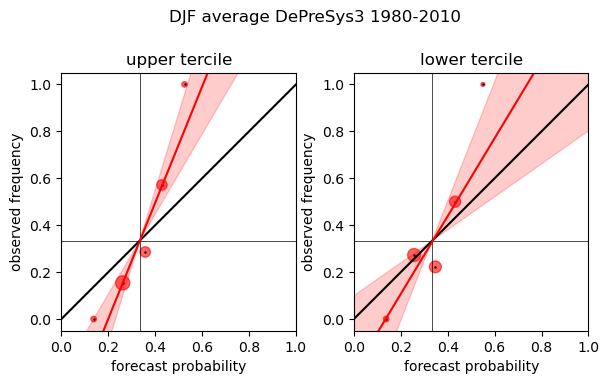

In [7]:
#create reliability plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

fig, axs = plt.subplots(1,2, figsize=(6,4), dpi=100)
axs[0].set_aspect(1)
axs[1].set_aspect(1)
fig.tight_layout()
fig.suptitle('DJF average DePreSys3 '+s)

t=np.full(50,0.3333333)
x=np.linspace(0,1,50)
y=np.linspace(0,1,50)
yt=np.linspace(-0.05,1.05,50)
for i in range(2):
    axs[i].plot(x,t,c='black',linewidth=0.5)
    axs[i].plot(t,yt,c='black', linewidth=0.5)
    axs[i].plot(x,y,c='black')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([-0.05, 1.05])
    axs[i].set_xlabel('forecast probability')
    axs[i].set_ylabel('observed frequency')
    
#upper tercile data unadjusted
upperun=np.loadtxt("NAO_"+s+"dp3_coords_upper_tercile.txt")
wun=int(upperun.size/4)
NAO_upun = upperun.reshape(wun,4)
x_uun = NAO_upun[:,0]
y_uun = NAO_upun[:,1]
size_uun= NAO_upun[:,2]*8

pun=x_uun.reshape(-1,1)
modeluun= LinearRegression()
modeluun.fit(pun,y_uun,size_uun)
p_newun = x_uun
q_newun = modeluun.predict(p_newun[:, np.newaxis])
q_regun=modeluun.coef_
print(q_regun)
q_intun=modeluun.intercept_
axs[0].plot(x,q_regun*x+q_intun, c='red')

uncert_regun =np.loadtxt("uncert_reg_u"+s+"dp3.txt")

m1un=uncert_regun[0]
m2un=uncert_regun[1]
c1un=0.3333333-0.3333333*m1un
c2un=0.3333333-0.3333333*m2un

axs[0].fill_between(x, m1un*x+c1un, m2un*x+c2un,color='red', alpha=0.2)
axs[0].scatter(x_uun, y_uun, c='red', s=size_uun, alpha=0.6)
axs[0].scatter(x_uun, y_uun, c='black', s=0.5)


#lower tercile data unadjusted
lowerun=np.loadtxt("NAO_"+s+"dp3_coords_lower_tercile.txt")
wlun=int(lowerun.size/4)
NAO_loun = lowerun.reshape(wlun,4)
x_lun = NAO_loun[:,0]
y_lun = NAO_loun[:,1]
size_lun= NAO_loun[:,2]*8

plun=x_lun.reshape(-1,1)
modellun= LinearRegression()
modellun.fit(plun,y_lun,size_lun)
p_newlun = x_lun
q_newlun = modellun.predict(p_newlun[:, np.newaxis])
q_reglun=modellun.coef_
print(q_reglun)
q_intlun=modellun.intercept_
axs[1].plot(x,q_reglun*x+q_intlun, c='red')

uncert_reglun =np.loadtxt("uncert_reg_l"+s+"dp3.txt")

m1lun=uncert_reglun[0]
m2lun=uncert_reglun[1]
c1lun=0.3333333-0.3333333*m1lun
c2lun=0.3333333-0.3333333*m2lun

axs[1].fill_between(x, m1lun*x+c1lun, m2lun*x+c2lun, color='red', alpha=0.2)
axs[1].scatter(x_lun, y_lun, c='red', s=size_lun, alpha=0.6)
axs[1].scatter(x_lun, y_lun, c='black', s=0.5)




axs[0].set_title('upper tercile')
axs[1].set_title('lower tercile')
plt.show()

In [24]:
alpha=np.loadtxt("ERA20C_PCs_1902-2010_daily_jet_adjusted.txt")
beta=np.loadtxt("ERA20C_PCs_1902-2010_daily_jet_unadjusted.txt")

print(alpha-beta)


[  280.28825133   -66.72634218 -1033.60692901  2330.7775148
 -1647.45284174  2974.54804102   672.58312539  1710.97229071
  -926.55612604  1596.59310763 -1583.75810891 -2801.2650767
   245.01910376 -1457.11686183  -980.20721578  3770.787505
  1258.24179293   710.10393274 -2058.87362552  2427.54661801
 -1661.99195013 -1393.75472008  1102.79419139 -1679.82794091
 -1311.97138656  1565.49715113 -2472.67389309  2756.99914403
  -424.56825518  1234.48350066  3703.14003966  2554.41323258
  1994.27284296 -1384.03553522   129.26435798 -2278.46360485
  3218.16433842  -588.97982976  1253.13921339   442.07269062
  2928.38624594  -910.68743666  1943.55350338   469.62035149
   614.17283773  -251.89797738  -372.81784993  -772.03733564
  -253.79114199  1496.21803976    69.89425828  5220.14586264
  1230.64260911   323.9207881   2404.5226164  -2757.06565862
  1241.88054403  1580.43554097  -381.23572939  -960.0329902
 -1136.29477911  1956.78453609  1506.00223688  2315.03770886
 -2706.0411121   -556.5243929